In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import scipy.sparse as sparse
from tqdm import tqdm

In [2]:
n = 20
img = 0.8 + 0.2 * np.random.uniform(size=(n, n))
img[np.tril_indices_from(img)] -= 0.8
img = (img * 255)[:, :, None].astype(int)

In [3]:
img = (mpimg.imread("pictures/horse.png")[:, :, 0][:, :, None] * 255).astype(int)

In [4]:
img = (mpimg.imread("pictures/cat_color.png")[:, :, :4] * 255).astype(int)

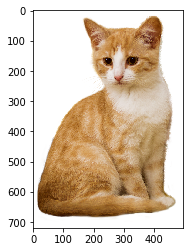

In [ ]:
plt.imshow(img)

In [ ]:
D = 2 + img.shape[2]

lambd = 20
sigma_xy = 100
sigma_l = 50
sigma_uv = 50
sigma_alpha = 50

sigma = np.array(
    [sigma_xy, sigma_xy, sigma_l, sigma_uv, sigma_uv, sigma_alpha]
)[:D]

grid_shape = np.hstack([
    (np.ceil(img.shape[:2] / sigma[:2]) + 1).astype(int),
    (np.ceil(255 / sigma[2:]) + 1).astype(int)
])

In [ ]:
grid_shape

array([9, 6, 7, 7, 7, 7])

In [ ]:
n_pixels = np.prod(img.shape[:2])
n_vertices = np.prod(grid_shape)

coord_to_vertex = np.arange(n_vertices).reshape(grid_shape).astype(int)

grid_indices = np.indices(grid_shape)
vertex_to_coord = np.stack([
    grid_indices[dim].flatten()
    for dim in range(D)
], axis=1)

In [ ]:
x_img = np.indices(img.shape[:2])[0].flatten()
y_img = np.indices(img.shape[:2])[1].flatten()

pos_img = np.hstack([
    x_img[:, None],
    y_img[:, None],
    img[x_img, y_img]
])

pos_grid = np.rint(pos_img / sigma).astype(int)

nearest_neighbors = coord_to_vertex[tuple(zip(*pos_grid))]
useful_vertices = np.sort(np.unique(nearest_neighbors))
n_useful_vertices = len(useful_vertices)

In [ ]:
S = sparse.lil_matrix((n_useful_vertices, n_pixels), dtype=np.float)

for uv_ind in tqdm(range(len(useful_vertices)), desc="Computing splat matrix"):
    uv = useful_vertices[uv_ind]
    nearby_pixels = np.where(nearest_neighbors == uv)[0]
    S[uv_ind, nearby_pixels] = 1

Computing splat matrix: 100%|██████████| 1895/1895 [00:00<00:00, 3914.24it/s]


In [ ]:
B = sparse.lil_matrix((n_vertices, n_vertices), dtype=np.float)
B[np.diag_indices_from(B)] = 6

possible_neighbor_steps = [
    np.array([0] * dim + [1] + [0] * (D - dim - 1))
    for dim in range(D)
] + [
    np.array([0] * dim + [-1] + [0] * (D - dim - 1))
    for dim in range(D)
]

for neighbor_step in tqdm(possible_neighbor_steps, desc="Computing blur matrix"):
    neighbors_coord = vertex_to_coord[np.arange(n_vertices)] + neighbor_step

    neighbors_coord_acceptable = True
    for dim, dim_size in enumerate(grid_shape):
        neighbors_coord_acceptable = (
            neighbors_coord_acceptable &
            (neighbors_coord[:, dim] >= 0) &
            (neighbors_coord[:, dim] < dim_size)
        )
    
    acceptable_neighbors = coord_to_vertex[
        tuple(zip(*neighbors_coord[neighbors_coord_acceptable]))
    ]
    vertices_with_acceptable_neighbors = np.arange(n_vertices)[neighbors_coord_acceptable]
    
    B[vertices_with_acceptable_neighbors, acceptable_neighbors] = 1
    
B = B[np.ix_(useful_vertices, useful_vertices)]

Computing blur matrix: 100%|██████████| 12/12 [00:03<00:00,  3.31it/s]


In [ ]:
def bistochastize(S, B, iterations=50):
    m = S.dot(np.ones(S.shape[1]))
    n = np.ones(B.shape[1])
    for it in range(iterations):
        new_n = np.sqrt((n * m) / (B.dot(n)))
        if np.linalg.norm(new_n - n) < 1e-5:
            break
        else:
            n = new_n
    Dn = sparse.csc_matrix(np.diag(n))
    Dm = sparse.csc_matrix(np.diag(m))
    return Dn, Dm

In [ ]:
def M_jacobi(y, A):
    return y / np.diagonal(A)

def prec_conj_grad(x_init, A, b, M_1, iterations=50):
    x = x_init
    r = b - A.dot(x)
    d = M_1(r, A)
    delta_new = np.float(r.dot(d.T))
    for it in range(iterations):
        q = A.dot(d.T)
        alpha = np.float(delta_new / d.dot(q))
        x = x + alpha * d
        r = r - alpha * q.T
        s = M_1(r, A)
        delta_old = delta_new
        delta_new = r.dot(s.T)
        beta = delta_new / delta_old
        d = s + beta * d
    return x.T

In [ ]:
Dn, Dm = bistochastize(S, B)

In [ ]:
new_img = np.empty_like(img)

for channel in tqdm(range(D-2), desc="Filtering channels"):
    T = img[:, :, channel].flatten()
    C = np.ones_like(T)

    A = lambd * (Dm - Dn.dot(B).dot(Dn)) + np.diag(S.dot(C))
    b = S.dot(C * T)
    c = 0.5 * (C * T).dot(T)

    y_flat = S.dot(C * T) / S.dot(C)
    y = prec_conj_grad(y_flat, A, b, M_jacobi)
    x = S.T.dot(y).reshape(img.shape[:2])
    
    new_img[:, :, channel] = x

Filtering channels: 100%|██████████| 4/4 [00:04<00:00,  1.21s/it]


In [ ]:
# img, new_img = img[:, :, 0], new_img[:, :, 0]

fig, ax = plt.subplots(1, 3, figsize=(18, 9))
ax[0].imshow(img)
ax[1].imshow(new_img)
ax[2].imshow((2 * img - new_img).astype(int))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [ ]:
def bilateral_representation(V, sigma):
    grid_shape = np.ceil((V.max(axis=0) / sigma) + 1).astype(int)
    
    n_abstract_pixels = len(V)
    n_vertices = np.prod(grid_shape)

    coord_to_vertex = np.arange(n_vertices).reshape(grid_shape).astype(int)

    grid_indices = np.indices(grid_shape)
    vertex_to_coord = np.stack([
        grid_indices[dim].flatten()
        for dim in range(D)
    ], axis=1)
    
    pos_grid = np.rint(V / sigma).astype(int)

    nearest_neighbors = coord_to_vertex[tuple(zip(*pos_grid))]
    useful_vertices = np.sort(np.unique(nearest_neighbors))
    n_useful_vertices = len(useful_vertices)
    
    S = sparse.lil_matrix((n_useful_vertices, n_abstract_pixels), dtype=np.float)
    
    for uv_ind in tqdm(range(len(useful_vertices)), desc="Computing splat matrix"):
        uv = useful_vertices[uv_ind]
        nearby_pixels = np.where(nearest_neighbors == uv)[0]
        S[uv_ind, nearby_pixels] = 1
        
    return S, vertex_to_coord[useful_vertices]

In [ ]:
V = vertex_to_coord
S_pyr = [S]
while len(V) > 1:
    Sk, V = bilateral_representation(V, 2 * np.ones(D))
    S_pyr_append(Sk)
    print(Sk.shape)